<a href="https://colab.research.google.com/github/k1-furuya/rstan001/blob/main/vouchers%E7%94%B7%E5%A5%B3%E5%88%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Angrist（2002）の1990年代のコロンビアにおいて、12万人ほどのSecondary School(日本の中高生に相当)に、応募者の中から、ランダムに選択した当選者に私立学校の学費の半分程度を政府が肩代わりする割引券を配布した。

この介入での特徴は以下の二つである。

1つは当選したグループの私立学校へ通う割合が大きくなるという想定。

2つ目はこの割引券は落第すると権利を失ってしまうということである。
この仕組みによって、生徒が落第しないように努力するインセンティブがあり、親としても子に一定の成績をおさめるように働きかけるインセンティブが存在することになる。
これにより留年の減少が起こると期待される。

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [9]:
df = pd.read_csv("vouchers.csv")
df.head()

,Unnamed: 0,ID,BOG95SMP,BOG97SMP,JAM93SMP,SEX,AGE,AGE2,HSVISIT,SCYFNSH,...,REPT,NREPT,FINISH6,FINISH7,FINISH8,SEX_MISS,USNGSCH,HOURSUM,TAB3SMPL,WORKING3
0,1,NaN,0,0,0,NaN,NaN,NaN,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,0,0,0,1.0,NaN,12.0,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2.0,0,0,0,0.0,NaN,13.0,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.0,1,0,0,0.0,14.0,12.0,0.0,8,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5,4.0,1,0,0,1.0,14.0,12.0,0.0,8,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [35]:
# 分析に使用する変数を選択
columns = ['SEX2','VOUCH0', 'FINISH6', 'REPT6', 'NREPT', 'INSCHL',
                    'FINISH7', 'PRSCH_C', 'FINISH8', 'TOTSCYRS', 'REPT']

# 選択した変数のみを含むデータフレームを作成
df = df[columns]

# 欠損値を含む行を削除
cleaned_df =df.dropna()

# 削除後のデータの基本統計量を表示
cleaned_df.describe()


,SEX2,VOUCH0,FINISH6,REPT6,NREPT,INSCHL,FINISH7,PRSCH_C,FINISH8,TOTSCYRS,REPT
count,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000,1906.000000
mean,0.491081,0.533578,0.941763,0.140084,0.186254,0.863589,0.664218,0.660546,0.526233,3.390871,0.166317
std,0.500052,0.499002,0.234253,0.387195,0.441234,0.343315,0.472387,0.473648,0.499442,1.242257,0.372463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000
max,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000


In [36]:
# 性別でデータセットを分割
male_df = cleaned_df[cleaned_df['SEX2'] == 1]
female_df = cleaned_df[cleaned_df['SEX2'] == 0]

In [37]:
# 男性のデータに対する目的変数と説明変数の分離、正規化の処理
y_male = male_df.pop("VOUCH0")
X_male = male_df.drop(columns=['SEX2'])  # 性別の列は除去

# 正規化の処理（お作法）
X_male -= X_male.mean()
X_male /= X_male.std()


# 女性のデータに対する目的変数と説明変数の分離、正規化の処理
y_female = female_df.pop("VOUCH0")
X_female = female_df.drop(columns=['SEX2'])  # 性別の列は除去

# 正規化の処理（お作法）
X_female -= X_female.mean()
X_female /= X_female.std()


In [38]:
display(X_male.head())

,FINISH6,REPT6,NREPT,INSCHL,FINISH7,PRSCH_C,FINISH8,TOTSCYRS,REPT
4,0.286345,-0.390868,-0.453476,0.41209,0.732374,0.734096,1.016699,0.521563,-0.484332
5,0.286345,-0.390868,-0.453476,0.41209,0.732374,-1.360764,1.016699,0.521563,-0.484332
10,0.286345,-0.390868,-0.453476,0.41209,0.732374,-1.360764,1.016699,0.521563,-0.484332
16,0.286345,-0.390868,-0.453476,-2.42406,0.732374,-1.360764,-0.982524,-1.097618,-0.484332
21,0.286345,-0.390868,-0.453476,0.41209,-1.363963,0.734096,-0.982524,0.521563,-0.484332


In [39]:
# 男性用データセットの変数一覧
columns_male = X_male.columns.values

# 女性用データセットの変数一覧
columns_female = X_female.columns.values


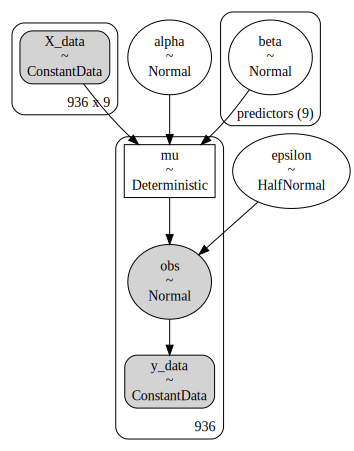

In [40]:
import pymc as pm
import arviz as az
# 無情報事前分布を用いたモデルの定義
with pm.Model(coords={'predictors': columns_male}) as model:
    # 定数データとしてXとyをモデルに追加
    X_data = pm.ConstantData('X_data', X_male)
    y_data = pm.ConstantData('y_data', y_male)

    # alpha（切片）の事前分布を設定（広範囲の正規分布）
    alpha = pm.Normal('alpha', mu=0.0, sigma=1.0)

    # beta（各説明変数の係数）の事前分布を設定（広範囲の正規分布）
    beta = pm.Normal('beta', mu=0.0, sigma=1.0, dims='predictors')

    # epsilon（誤差項の標準偏差）の事前分布を設定（広範囲のHalfNormal分布）
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # mu（期待値）の計算
    mu = pm.Deterministic('mu', alpha + pm.math.dot(X_data, beta))

    # 観測データに基づく確率分布を定義
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=y_data)

# モデルのグラフィカルな表現を確認（省略可）
g = pm.model_to_graphviz(model)
g


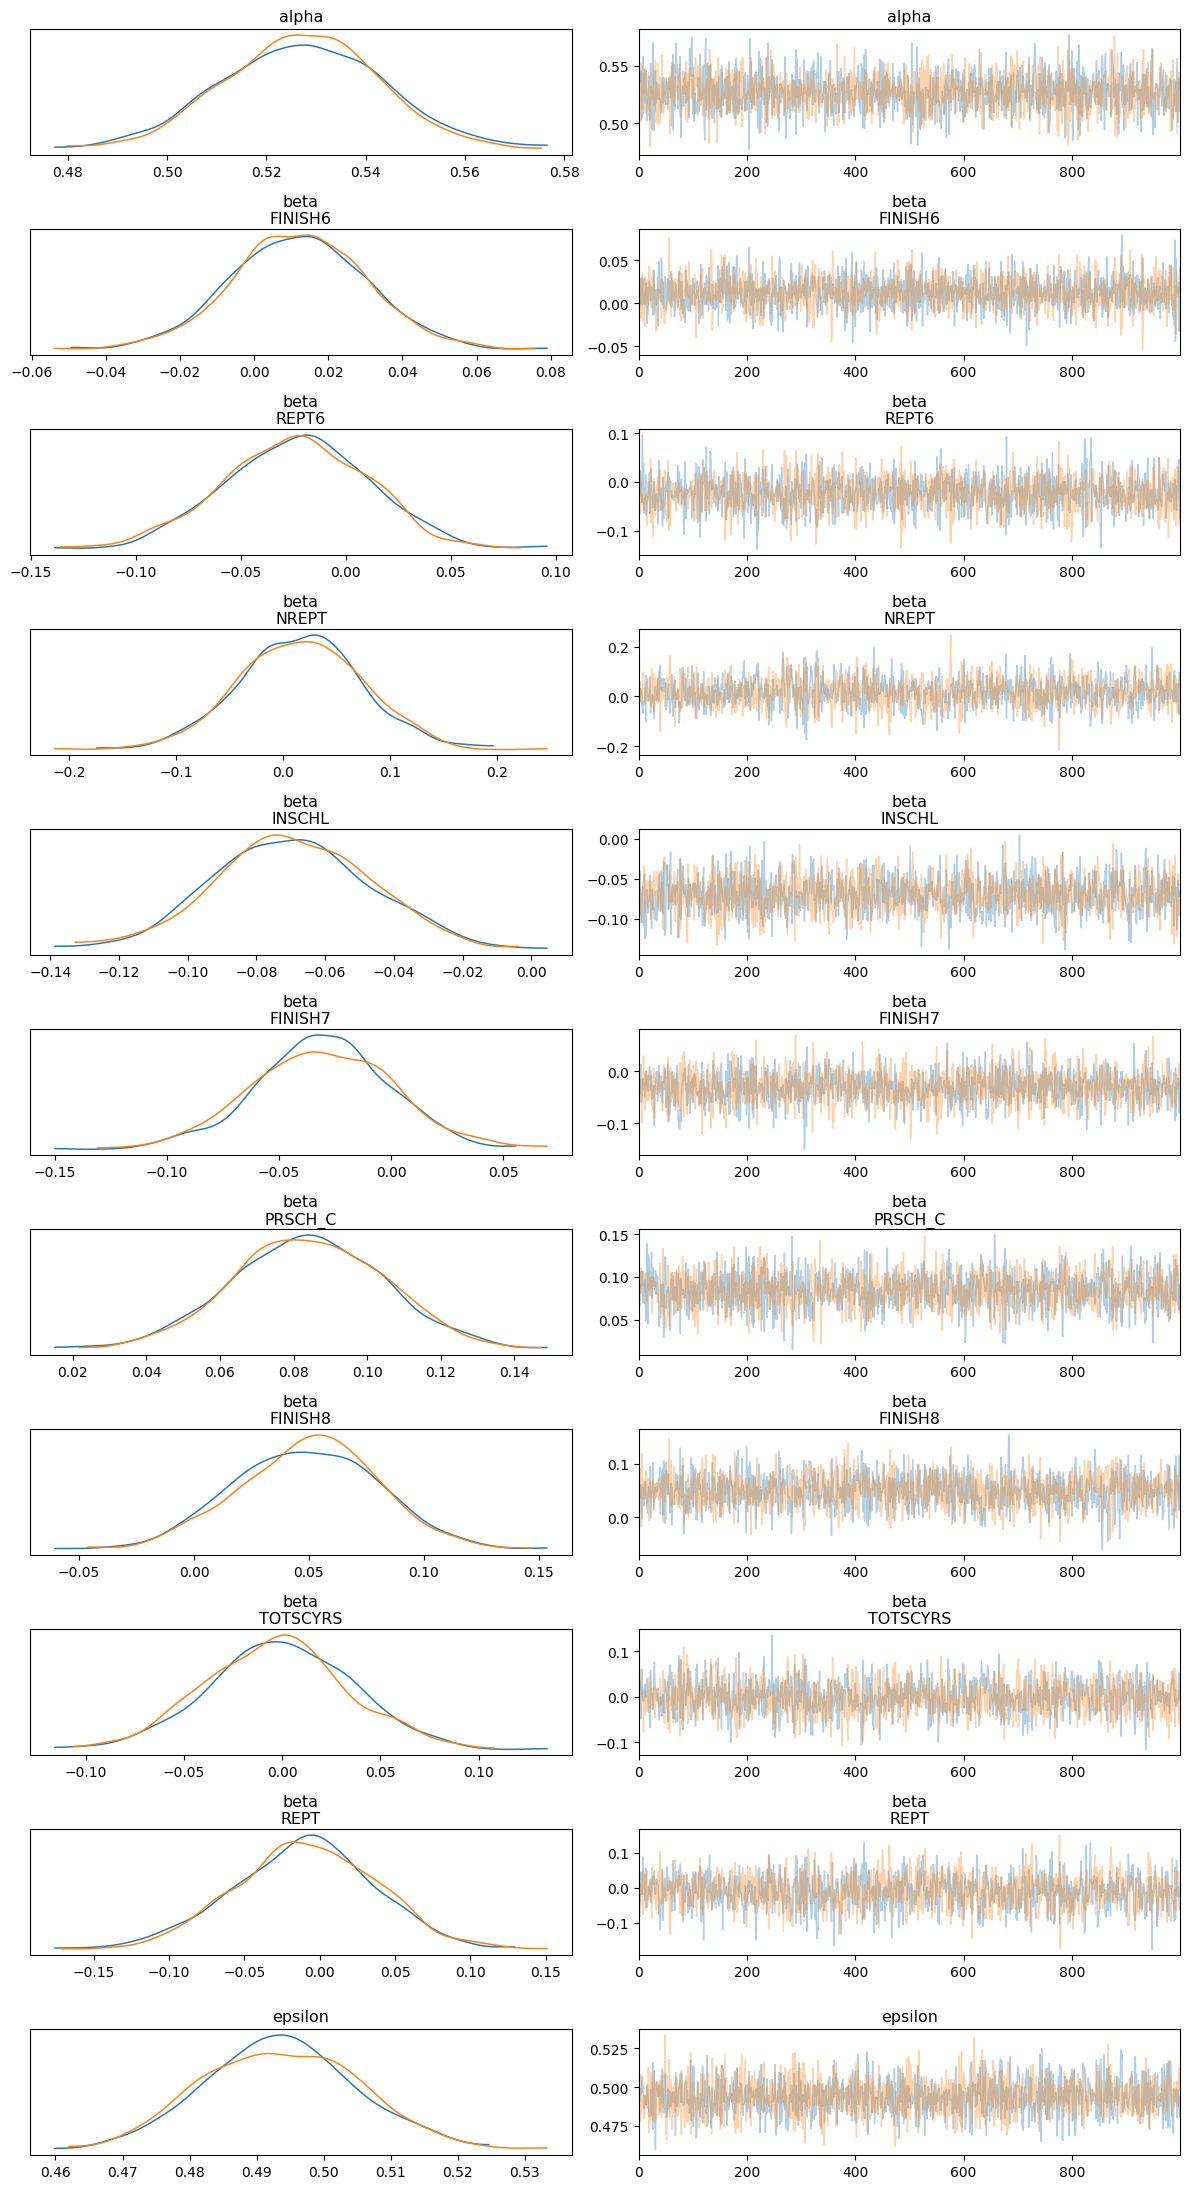

In [41]:
with model:
    idata1 = pm.sample(random_seed=42, target_accept=0.95)

# plot_trace関数で推論結果の確認
az.plot_trace(idata1, var_names=['alpha', 'beta', 'epsilon'], compact=False)
plt.tight_layout();

In [42]:
summary = az.summary(idata1, var_names=['alpha', 'beta', 'epsilon'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.527,0.016,0.498,0.558,0.000,0.000,2675.0,1603.0,1.0
beta[FINISH6],0.012,0.018,-0.024,0.045,0.000,0.000,2509.0,1608.0,1.0
beta[REPT6],-0.024,0.035,-0.092,0.035,0.001,0.001,1902.0,1186.0,1.0
beta[NREPT],0.016,0.057,-0.089,0.124,0.002,0.001,1313.0,1251.0,1.0
beta[INSCHL],-0.070,0.023,-0.111,-0.027,0.001,0.000,1569.0,1162.0,1.0
beta[FINISH7],-0.031,0.031,-0.093,0.024,0.001,0.001,2044.0,1383.0,1.0
beta[PRSCH_C],0.084,0.021,0.046,0.123,0.001,0.000,1634.0,1408.0,1.0
beta[FINISH8],0.049,0.031,-0.011,0.102,0.001,0.001,1843.0,1538.0,1.0
beta[TOTSCYRS],-0.002,0.036,-0.072,0.062,0.001,0.001,1720.0,1285.0,1.0
beta[REPT],-0.010,0.047,-0.104,0.068,0.001,0.001,1438.0,1265.0,1.0


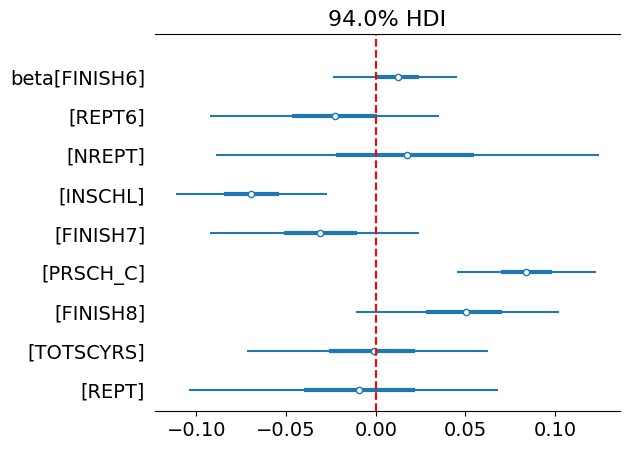

In [43]:
az.plot_forest(idata1, combined=True, var_names=['beta'])

# 特定の位置に縦線を追加
plt.axvline(x=0.0, color='r', linestyle='--')

# 表示 # 男
plt.show()

PRSCH_C 当選から3年経過した調査の段階で私立学校に通っているかどうか

INSCHL 私立と公立を問わず通学の傾向を示す

REPT6 6年生で留年したかを示す

NREPT 3年間で何回留年したかを示す

REPT 調査までに一度でも留年したかを示す

FINISH6-8 当選から調査までの3年間で6,7,8年生の修了を表す

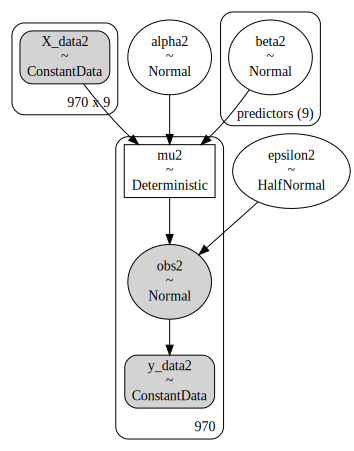

In [44]:
# 無情報事前分布を用いたモデルの定義
with pm.Model(coords={'predictors': columns_female}) as model2:
    # 定数データとしてXとyをモデルに追加
    X_data2 = pm.ConstantData('X_data2', X_female)
    y_data2 = pm.ConstantData('y_data2', y_female)

    # alpha（切片）の事前分布を設定（広範囲の正規分布）
    alpha2 = pm.Normal('alpha2', mu=0.0, sigma=1.0)

    # beta（各説明変数の係数）の事前分布を設定（広範囲の正規分布）
    beta2 = pm.Normal('beta2', mu=0.0, sigma=1.0, dims='predictors')

    # epsilon（誤差項の標準偏差）の事前分布を設定（広範囲のHalfNormal分布）
    epsilon2 = pm.HalfNormal('epsilon2', sigma=1.0)

    # mu（期待値）の計算
    mu2 = pm.Deterministic('mu2', alpha2 + pm.math.dot(X_data2, beta2))

    # 観測データに基づく確率分布を定義
    obs2 = pm.Normal('obs2', mu=mu2, sigma=epsilon2, observed=y_data2)

# モデルのグラフィカルな表現を確認（省略可）
g = pm.model_to_graphviz(model2)
g


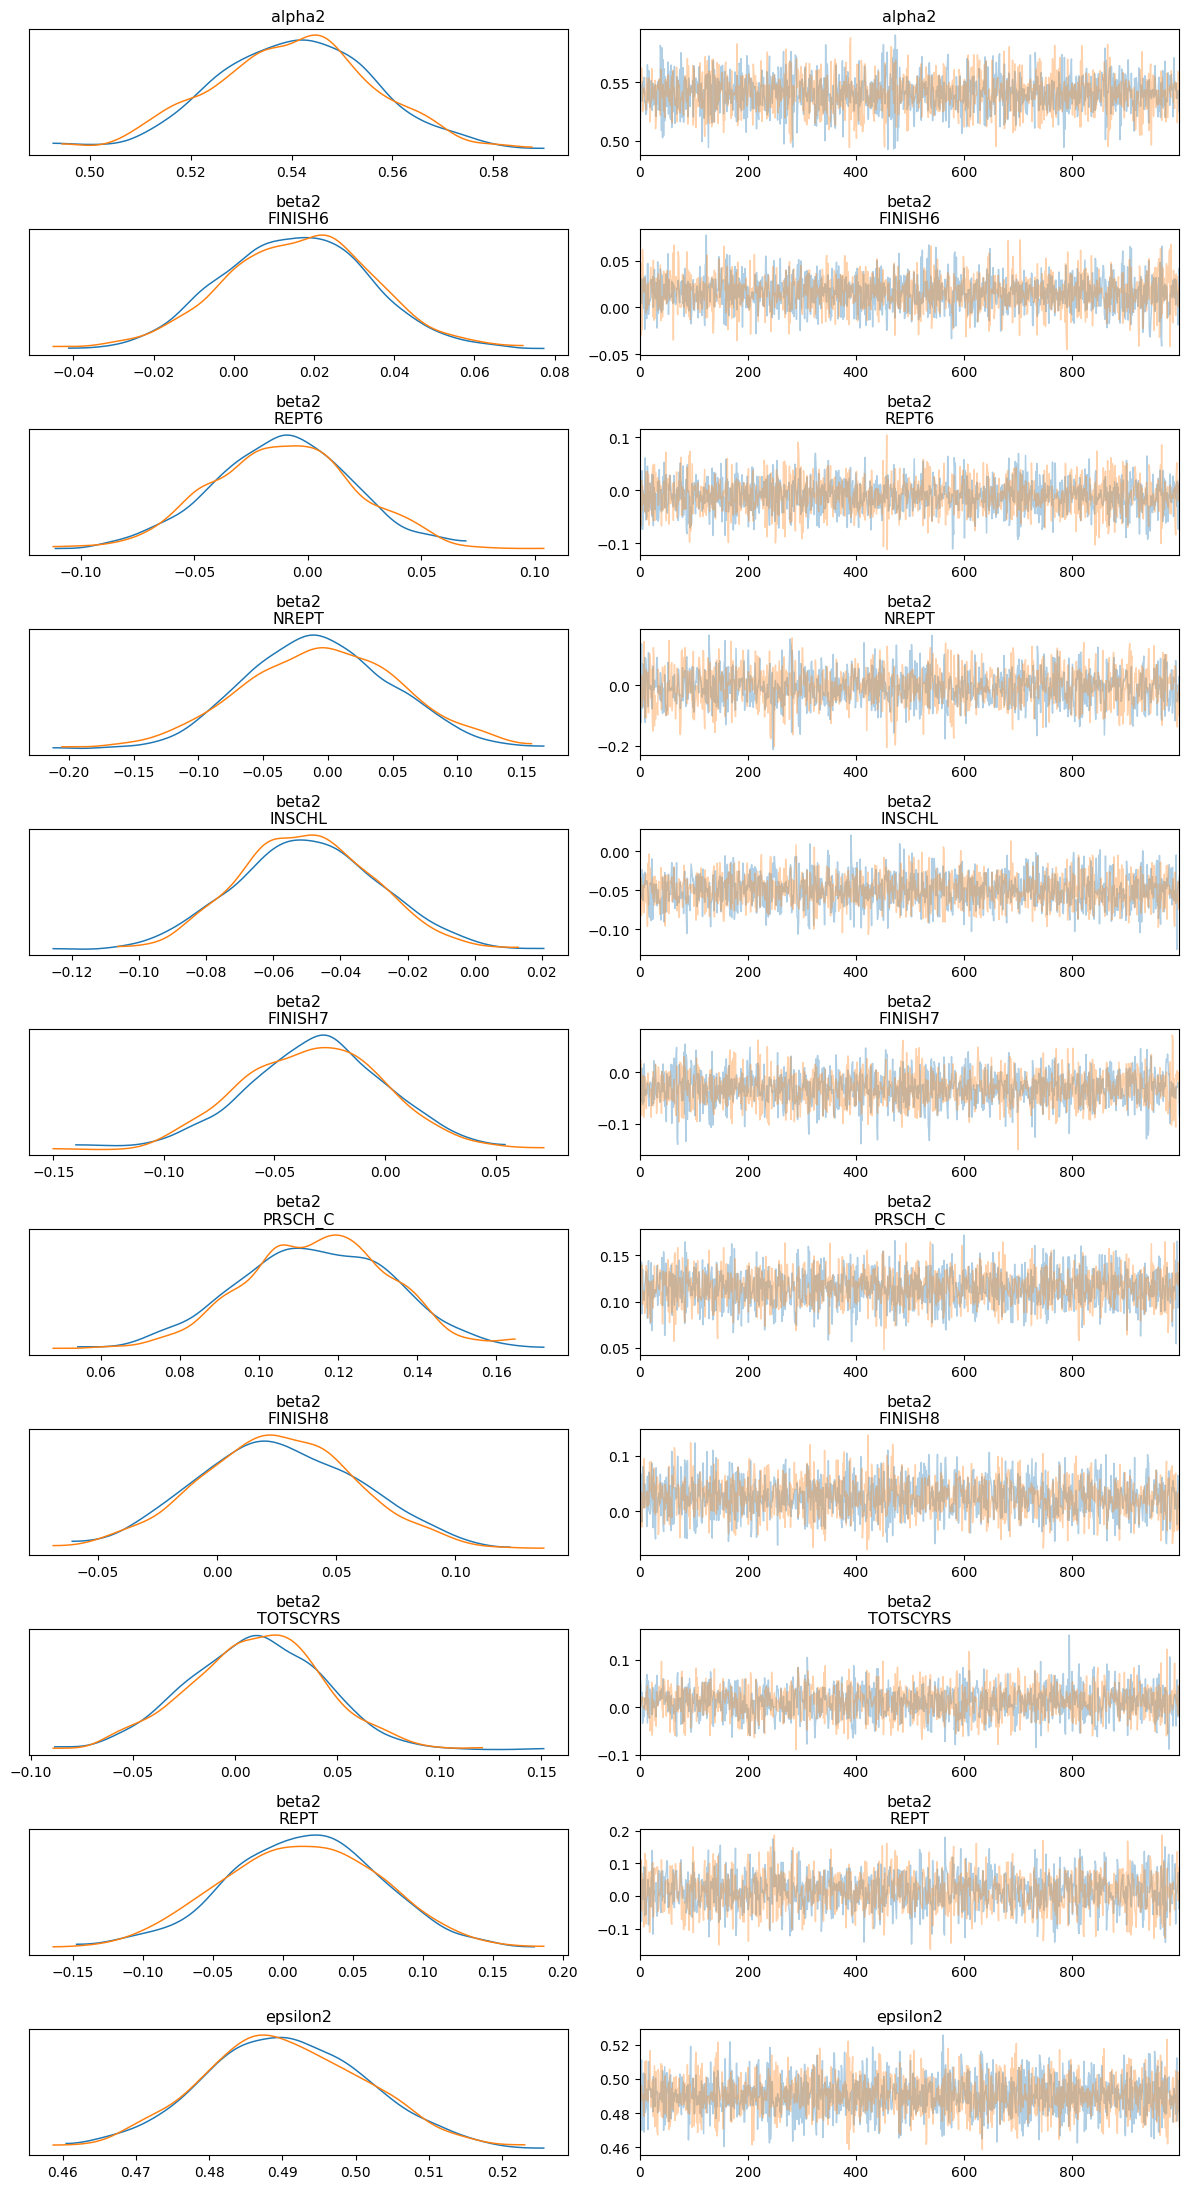

In [45]:
with model2:
    idata2 = pm.sample(random_seed=42, target_accept=0.95)

# plot_trace関数で推論結果の確認
az.plot_trace(idata2, var_names=['alpha2', 'beta2', 'epsilon2'], compact=False)
plt.tight_layout();

In [46]:
summary = az.summary(idata2, var_names=['alpha2', 'beta2', 'epsilon2'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha2,0.540,0.016,0.511,0.569,0.000,0.000,2903.0,1398.0,1.0
beta2[FINISH6],0.016,0.018,-0.021,0.049,0.000,0.000,2938.0,1360.0,1.0
beta2[REPT6],-0.011,0.031,-0.067,0.051,0.001,0.001,3016.0,1339.0,1.0
beta2[NREPT],-0.006,0.060,-0.114,0.111,0.001,0.001,1883.0,1306.0,1.0
beta2[INSCHL],-0.050,0.020,-0.088,-0.013,0.000,0.000,2092.0,1508.0,1.0
beta2[FINISH7],-0.032,0.032,-0.090,0.028,0.001,0.001,2287.0,1229.0,1.0
beta2[PRSCH_C],0.115,0.019,0.079,0.151,0.000,0.000,2553.0,1699.0,1.0
beta2[FINISH8],0.026,0.033,-0.036,0.089,0.001,0.001,2086.0,1530.0,1.0
beta2[TOTSCYRS],0.010,0.032,-0.049,0.071,0.001,0.001,2090.0,1437.0,1.0
beta2[REPT],0.014,0.057,-0.101,0.112,0.001,0.001,2040.0,1281.0,1.0


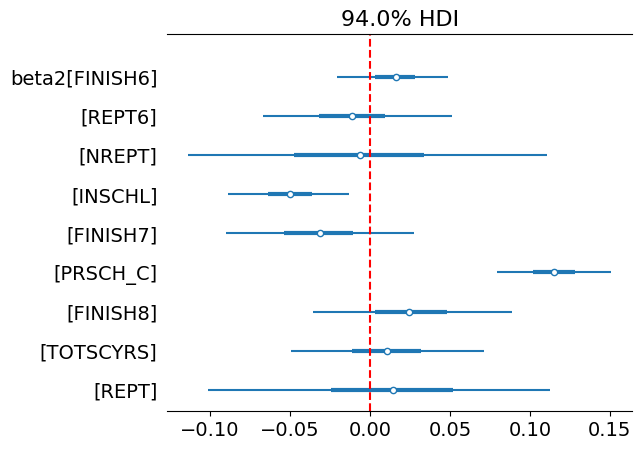

In [47]:
az.plot_forest(idata2, combined=True, var_names=['beta2'])

# 特定の位置に縦線を追加
plt.axvline(x=0.0, color='r', linestyle='--')

# 表示 # 女
plt.show()

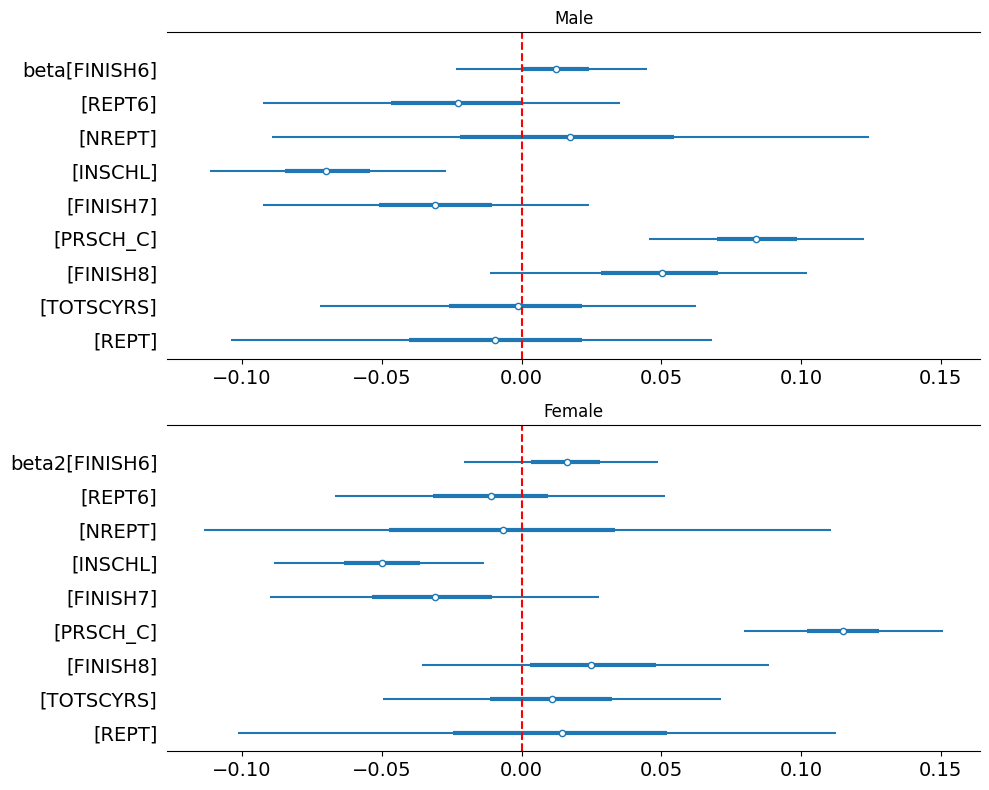

In [48]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # サブプロットを2つ作成

# 男性用のプロット
az.plot_forest(idata1, combined=True, var_names=['beta'], ax=axs[0])
axs[0].axvline(x=0.0, color='r', linestyle='--')
axs[0].set_title('Male')  # サブプロットにタイトルを追加

# 女性用のプロット
az.plot_forest(idata2, combined=True, var_names=['beta2'], ax=axs[1])
axs[1].axvline(x=0.0, color='r', linestyle='--')
axs[1].set_title('Female')  # サブプロットにタイトルを追加

# 両方のプロットのx軸の範囲を統一する
xmin = min(axs[0].get_xlim()[0], axs[1].get_xlim()[0])
xmax = max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])
axs[0].set_xlim(xmin, xmax)
axs[1].set_xlim(xmin, xmax)

plt.tight_layout()  # サブプロット間のスペースを調整
plt.show()  # 全てのプロットを表示
# 男女並べて表示

説明変数の意味（再掲）

PRSCH_C 当選から3年経過した調査の段階で私立学校に通っているかどうか

INSCHL 私立と公立を問わず通学の傾向を示す

REPT6 6年生で留年したかを示す

NREPT 3年間で何回留年したかを示す

REPT 調査までに一度でも留年したかを示す

FINISH6-8 当選から調査までの3年間で6,7,8年生の修了を表す

以上の結果から、男女ともにINSCHL（私立公立問わず通学の傾向）にマイナスの有意、PRSCH_C（当選から3年経過した調査の段階で私立学校に通っているか）にプラスの有意な差が見られた。INSCHLのマイナスの有意は直観に反する結果となったので、より深堀する必要があるかもしれない。

